In [1]:
import re, io
import os, json
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from data_ingestor import *
from time_series import *

plt.style.use('seaborn')
%matplotlib inline

from variables import init_variables
path_to_json, column_dict, inconsistent_col, keys = init_variables()

Importing plotly failed. Interactive plots will not work.


In [2]:
master_df = read_all_json_files(path_to_json, column_dict, inconsistent_col, keys)
master_df_clean = maintain_datatype(master_df)
master_df_clean = drop_non_numeric_invoice(master_df_clean)

##### 1. UK time series analysis

In [3]:
df_UK = master_df_clean[master_df_clean['country']=='United Kingdom']

In [4]:
df_day_UK = df_UK.groupby(['year', 'month', 'day']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first',}).reset_index()
df_day_UK = create_date_col(df_day_UK)
df_day_UK = df_day_UK[df_day_UK['price']<=20000]
df_day_UK.head()

,year,month,day,times_viewed,price,country,Date
0,2017,11,28,12739,12836.40,United Kingdom,2017-11-28
1,2017,11,29,13628,13059.15,United Kingdom,2017-11-29
2,2017,11,30,15196,10865.20,United Kingdom,2017-11-30
3,2017,12,1,11607,9068.60,United Kingdom,2017-12-01
4,2017,12,2,3101,1263.28,United Kingdom,2017-12-02


In [5]:
ts_UK = df_day_UK[['price', 'Date']].set_index('Date') # Set Date as index
ts_UK = ts_UK['price']

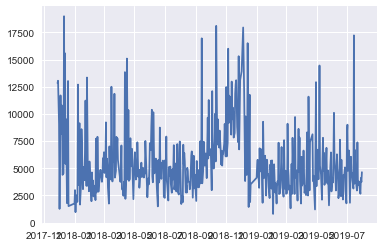

In [6]:
plt.plot(ts_UK)

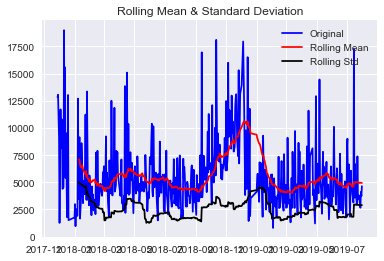

Results of Dickey-Fuller Test:
Test Statistic                  -4.127851
p-value                          0.000871
#Lags Used                       6.000000
Number of Observations Used    479.000000
Critical Value (1%)             -3.444076
Critical Value (5%)             -2.867593
Critical Value (10%)            -2.569994
dtype: float64


In [7]:
test_stationarity(ts_UK)

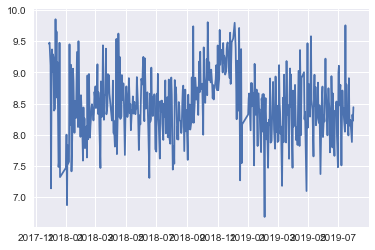

In [8]:
ts_log_UK = np.log(ts_UK)
plt.plot(ts_log_UK)

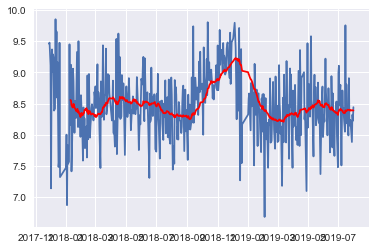

In [9]:
moving_avg_UK = ts_log_UK.rolling(30).mean()
plt.plot(ts_log_UK)
plt.plot(moving_avg_UK, color='red')

In [10]:
ts_log_moving_avg_diff_UK = ts_log_UK - moving_avg_UK

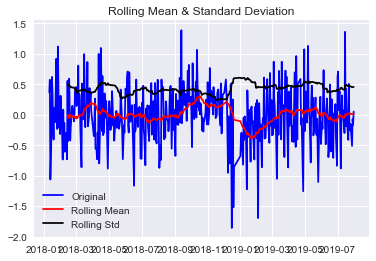

Results of Dickey-Fuller Test:
Test Statistic                -5.843715e+00
p-value                        3.725692e-07
#Lags Used                     5.000000e+00
Number of Observations Used    4.510000e+02
Critical Value (1%)           -3.444933e+00
Critical Value (5%)           -2.867970e+00
Critical Value (10%)          -2.570195e+00
dtype: float64


In [11]:
ts_log_moving_avg_diff_UK.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff_UK)

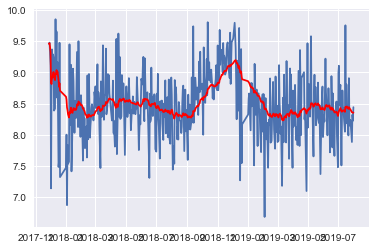

In [12]:
expwighted_avg_UK = ts_log_UK.ewm(halflife=12).mean()
plt.plot(ts_log_UK)
plt.plot(expwighted_avg_UK, color='red')

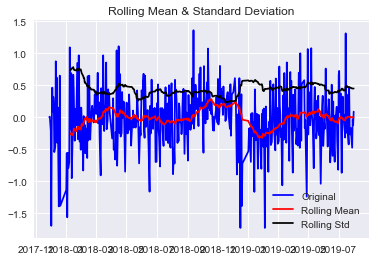

Results of Dickey-Fuller Test:
Test Statistic                -6.433599e+00
p-value                        1.673874e-08
#Lags Used                     5.000000e+00
Number of Observations Used    4.800000e+02
Critical Value (1%)           -3.444047e+00
Critical Value (5%)           -2.867580e+00
Critical Value (10%)          -2.569987e+00
dtype: float64


In [13]:
ts_log_ewma_diff_UK = ts_log_UK - expwighted_avg_UK
test_stationarity(ts_log_ewma_diff_UK)

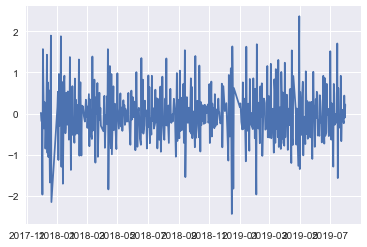

In [14]:
ts_log_diff_UK = ts_log_UK - ts_log_UK.shift()
plt.plot(ts_log_diff_UK)

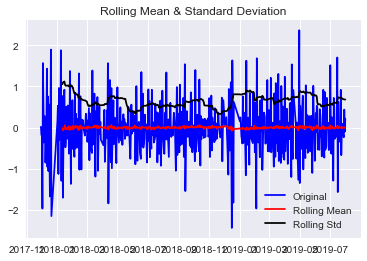

Results of Dickey-Fuller Test:
Test Statistic                -8.221835e+00
p-value                        6.398774e-13
#Lags Used                     1.600000e+01
Number of Observations Used    4.680000e+02
Critical Value (1%)           -3.444400e+00
Critical Value (5%)           -2.867736e+00
Critical Value (10%)          -2.570070e+00
dtype: float64


In [15]:
ts_log_diff_UK.dropna(inplace=True)
test_stationarity(ts_log_diff_UK)

/Users/aishwarya.das1ibm.com/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


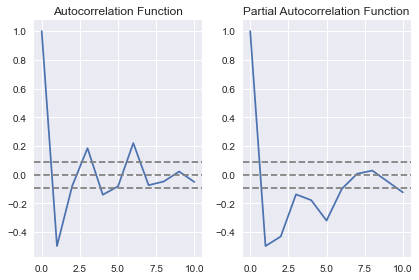

In [16]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff_UK, nlags=10)
lag_pacf = pacf(ts_log_diff_UK, nlags=10, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff_UK)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff_UK)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff_UK)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff_UK)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [17]:
ts_log_UK = np.log(ts_UK)
ts_log_diff_UK = ts_log_UK - ts_log_UK.shift()
ts_log_diff_UK.dropna(inplace=True)

/Users/aishwarya.das1ibm.com/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aishwarya.das1ibm.com/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: nan')

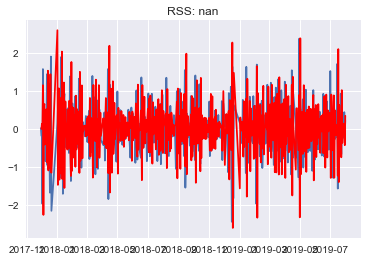

In [18]:
from statsmodels.tsa.arima_model import ARIMA

model_UK = ARIMA(ts_log_diff_UK, order=(1, 1, 0))  
results_AR_UK = model_UK.fit(disp=-1)  
plt.plot(ts_log_diff_UK)
plt.plot(results_AR_UK.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR_UK.fittedvalues-ts_log_diff_UK)**2))

/Users/aishwarya.das1ibm.com/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aishwarya.das1ibm.com/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 117.2059')

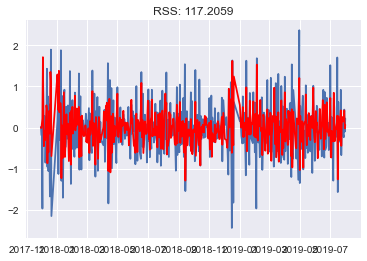

In [19]:
model_UK = ARIMA(ts_log_UK, order=(0, 1, 1))  
results_MA_UK = model_UK.fit(disp=-1)  
plt.plot(ts_log_diff_UK)
plt.plot(results_MA_UK.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA_UK.fittedvalues-ts_log_diff_UK)**2))

/Users/aishwarya.das1ibm.com/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aishwarya.das1ibm.com/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 116.6898')

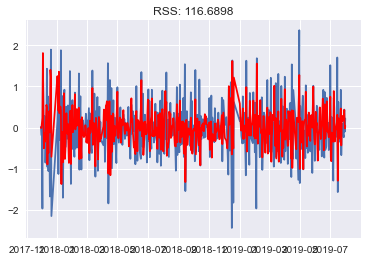

In [20]:
model_UK = ARIMA(ts_log_UK, order=(2, 1, 1))  
results_ARIMA_UK = model_UK.fit(disp=-1)  
plt.plot(ts_log_diff_UK)
plt.plot(results_ARIMA_UK.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_UK.fittedvalues-ts_log_diff_UK)**2))

Text(0.5, 1.0, 'RMSE: 3119482.7907')

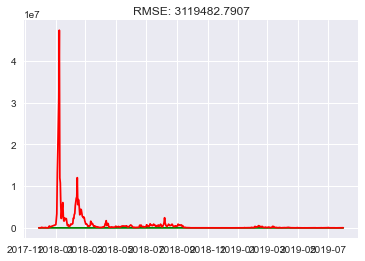

In [21]:
predictions_ARIMA_diff_UK = pd.Series(results_ARIMA_UK.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum_UK = predictions_ARIMA_diff_UK.cumsum()
predictions_ARIMA_log_UK = pd.Series(ts_log_UK.iloc[0], index=ts_log_UK.index)
predictions_ARIMA_log_UK = predictions_ARIMA_log_UK.add(predictions_ARIMA_diff_cumsum_UK,fill_value=0)
predictions_ARIMA_UK = np.exp(predictions_ARIMA_log_UK)
plt.plot(ts_UK, color='green')
plt.plot(predictions_ARIMA_UK, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_UK-ts_UK)**2)/len(ts_UK)))

#### Prophet

In [22]:
from fbprophet import Prophet
m_UK = Prophet()
ts_UK = make_continuous(df_day_UK)
df_UK = pd.DataFrame()
df_UK['ds'] = ts_UK.index
df_UK['y'] = ts_UK.price.values
m_UK.fit(df_UK)
future_UK = m_UK.make_future_dataframe(periods=30)
future_UK.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
636,2019-08-26
637,2019-08-27
638,2019-08-28
639,2019-08-29
640,2019-08-30


In [23]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m_UK, initial='500 days', period='150 days', horizon = '100 days')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-04-22 00:00:00 and 2019-04-22 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-04-23,5059.811526,1404.661455,9047.444669,8129.380000,2019-04-22
1,2019-04-24,4497.143730,899.929913,8342.137460,3820.160000,2019-04-22
2,2019-04-25,5344.602566,1565.660005,9184.719285,4316.710000,2019-04-22
3,2019-04-26,4527.286144,927.166060,8398.533978,3281.403333,2019-04-22
4,2019-04-27,3523.562208,-448.257638,7364.627397,2246.096667,2019-04-22


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-11-28,7813.0,5659.0,11711.0,7813.0,7813.0,807.0,807.0,807.0,807.0,807.0,807.0,0.0,0.0,0.0,8619.0
1,2017-11-29,7725.0,4593.0,10978.0,7725.0,7725.0,17.0,17.0,17.0,17.0,17.0,17.0,0.0,0.0,0.0,7742.0
2,2017-11-30,7637.0,5317.0,11350.0,7637.0,7637.0,789.0,789.0,789.0,789.0,789.0,789.0,0.0,0.0,0.0,8426.0
3,2017-12-01,7549.0,4406.0,10713.0,7549.0,7549.0,-50.0,-50.0,-50.0,-50.0,-50.0,-50.0,0.0,0.0,0.0,7499.0
4,2017-12-02,7461.0,3265.0,9717.0,7461.0,7461.0,-987.0,-987.0,-987.0,-987.0,-987.0,-987.0,0.0,0.0,0.0,6474.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,2019-11-04,4812.0,1334.0,10925.0,1128.0,8649.0,1204.0,1204.0,1204.0,1204.0,1204.0,1204.0,0.0,0.0,0.0,6016.0
707,2019-11-05,4812.0,1131.0,10644.0,1071.0,8732.0,807.0,807.0,807.0,807.0,807.0,807.0,0.0,0.0,0.0,5619.0
708,2019-11-06,4813.0,123.0,9824.0,1029.0,8794.0,17.0,17.0,17.0,17.0,17.0,17.0,0.0,0.0,0.0,4830.0
709,2019-11-07,4813.0,512.0,11180.0,966.0,8855.0,789.0,789.0,789.0,789.0,789.0,789.0,0.0,0.0,0.0,5602.0


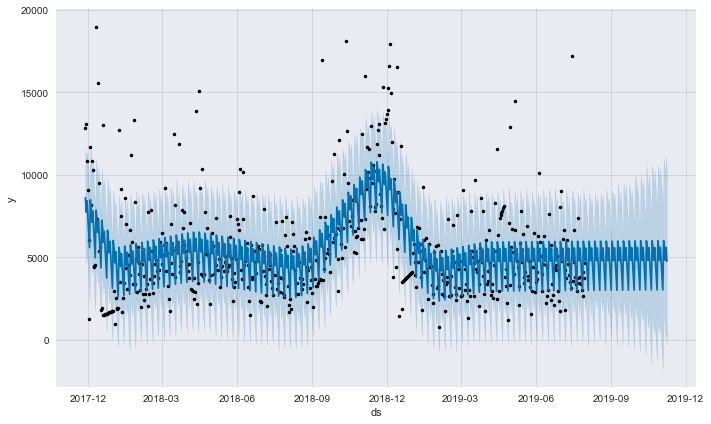

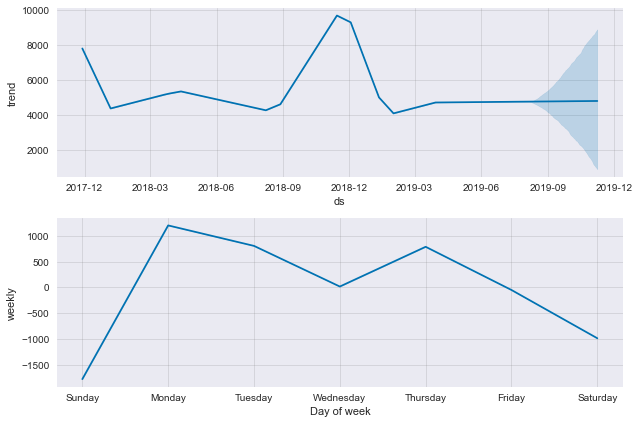

In [24]:
prophet_forecast(df_day_UK, 100)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


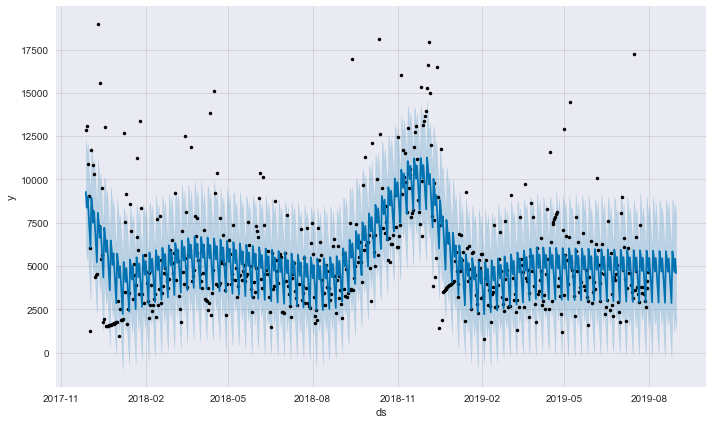

In [25]:
ts_UK = make_continuous(df_day_UK)
df_UK = pd.DataFrame()
df_UK['ds'] = ts_UK.index
df_UK['y'] = ts_UK.price.values
m2 = Prophet(changepoint_prior_scale=0.8)
m_UK = m2.fit(df_UK)
future = m2.make_future_dataframe(periods = 30)
forecast = m_UK.predict(future)
fig = m2.plot(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-11-28,7813.0,5545.0,11696.0,7813.0,7813.0,807.0,807.0,807.0,807.0,807.0,807.0,0.0,0.0,0.0,8619.0
1,2017-11-29,7725.0,4790.0,10819.0,7725.0,7725.0,17.0,17.0,17.0,17.0,17.0,17.0,0.0,0.0,0.0,7742.0
2,2017-11-30,7637.0,5192.0,11567.0,7637.0,7637.0,789.0,789.0,789.0,789.0,789.0,789.0,0.0,0.0,0.0,8426.0
3,2017-12-01,7549.0,4412.0,10639.0,7549.0,7549.0,-50.0,-50.0,-50.0,-50.0,-50.0,-50.0,0.0,0.0,0.0,7499.0
4,2017-12-02,7461.0,3226.0,9443.0,7461.0,7461.0,-987.0,-987.0,-987.0,-987.0,-987.0,-987.0,0.0,0.0,0.0,6474.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,2019-11-04,4812.0,1237.0,10731.0,1770.0,8448.0,1204.0,1204.0,1204.0,1204.0,1204.0,1204.0,0.0,0.0,0.0,6016.0
707,2019-11-05,4812.0,913.0,10271.0,1748.0,8502.0,807.0,807.0,807.0,807.0,807.0,807.0,0.0,0.0,0.0,5619.0
708,2019-11-06,4813.0,-7.0,9988.0,1704.0,8591.0,17.0,17.0,17.0,17.0,17.0,17.0,0.0,0.0,0.0,4830.0
709,2019-11-07,4813.0,988.0,10557.0,1672.0,8675.0,789.0,789.0,789.0,789.0,789.0,789.0,0.0,0.0,0.0,5602.0


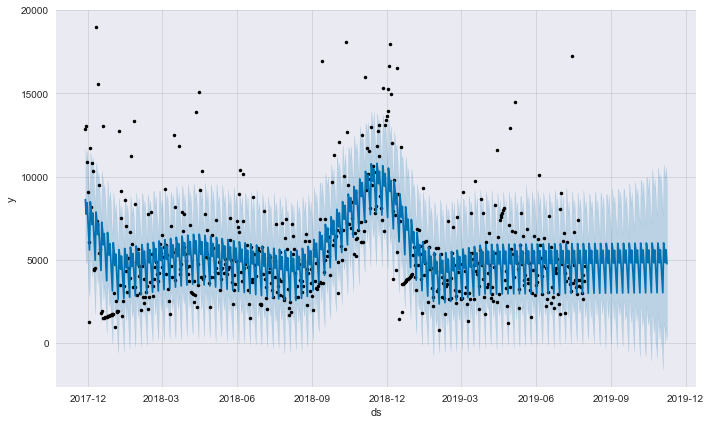

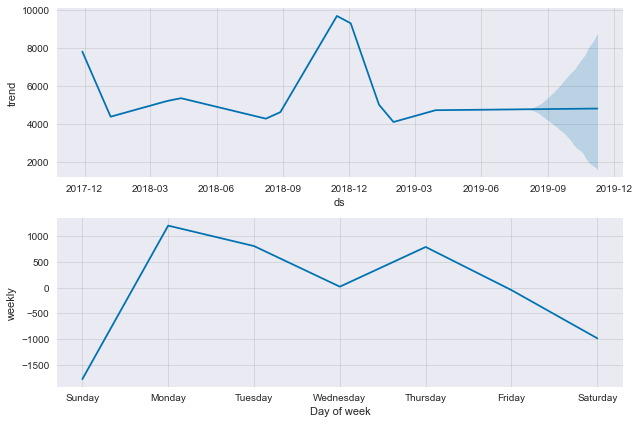

In [26]:
prophet_forecast(df_day_UK, 100, 0.5)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-11-28,8479.0,6170.0,12304.0,8479.0,8479.0,803.0,803.0,803.0,803.0,803.0,803.0,0.0,0.0,0.0,9282.0
1,2017-11-29,8354.0,5192.0,11080.0,8354.0,8354.0,15.0,15.0,15.0,15.0,15.0,15.0,0.0,0.0,0.0,8370.0
2,2017-11-30,8230.0,6097.0,12098.0,8230.0,8230.0,788.0,788.0,788.0,788.0,788.0,788.0,0.0,0.0,0.0,9018.0
3,2017-12-01,8106.0,4919.0,11199.0,8106.0,8106.0,-50.0,-50.0,-50.0,-50.0,-50.0,-50.0,0.0,0.0,0.0,8056.0
4,2017-12-02,7982.0,3934.0,10047.0,7982.0,7982.0,-986.0,-986.0,-986.0,-986.0,-986.0,-986.0,0.0,0.0,0.0,6996.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,2019-11-04,4531.0,335.0,11904.0,-255.0,9876.0,1207.0,1207.0,1207.0,1207.0,1207.0,1207.0,0.0,0.0,0.0,5738.0
707,2019-11-05,4529.0,105.0,11343.0,-353.0,9962.0,803.0,803.0,803.0,803.0,803.0,803.0,0.0,0.0,0.0,5332.0
708,2019-11-06,4527.0,-1166.0,10939.0,-439.0,10045.0,15.0,15.0,15.0,15.0,15.0,15.0,0.0,0.0,0.0,4543.0
709,2019-11-07,4526.0,-330.0,11879.0,-522.0,10149.0,788.0,788.0,788.0,788.0,788.0,788.0,0.0,0.0,0.0,5313.0


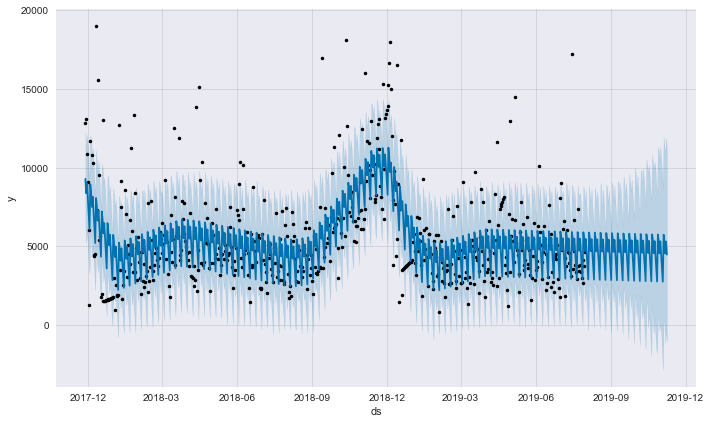

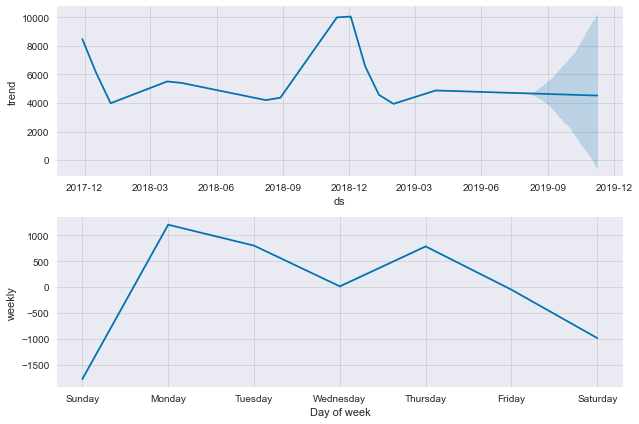

In [27]:
prophet_forecast(df_day_UK, 100, 0.8)